   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age    

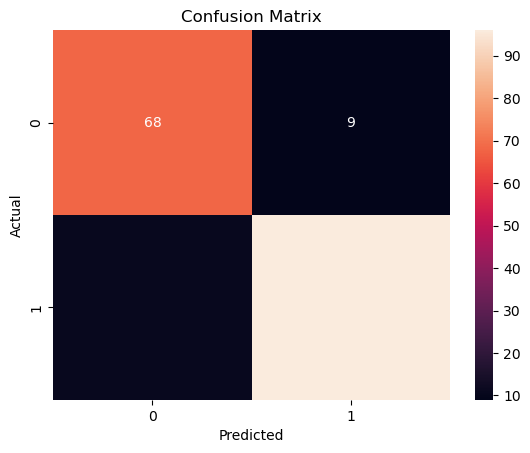

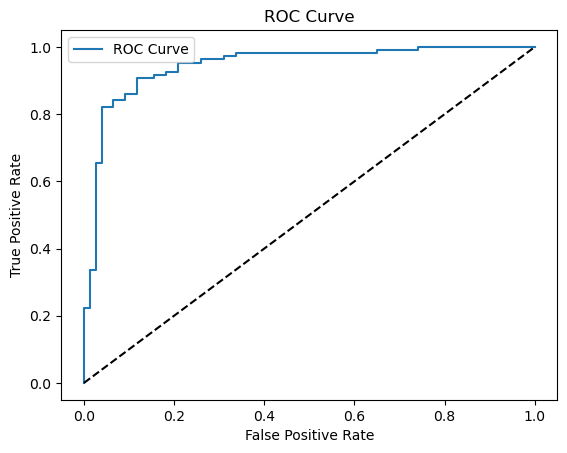

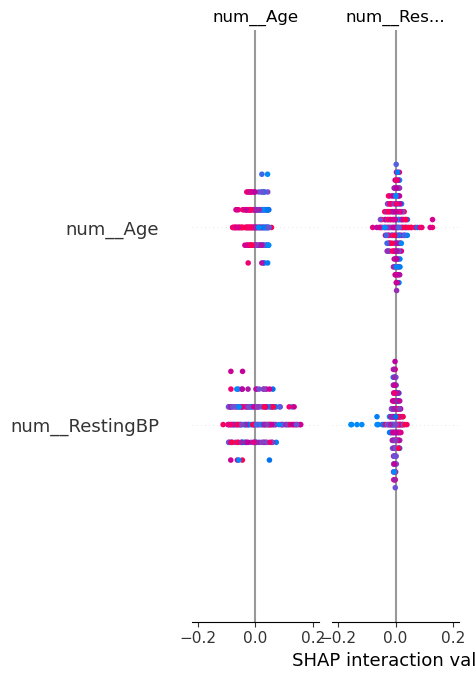

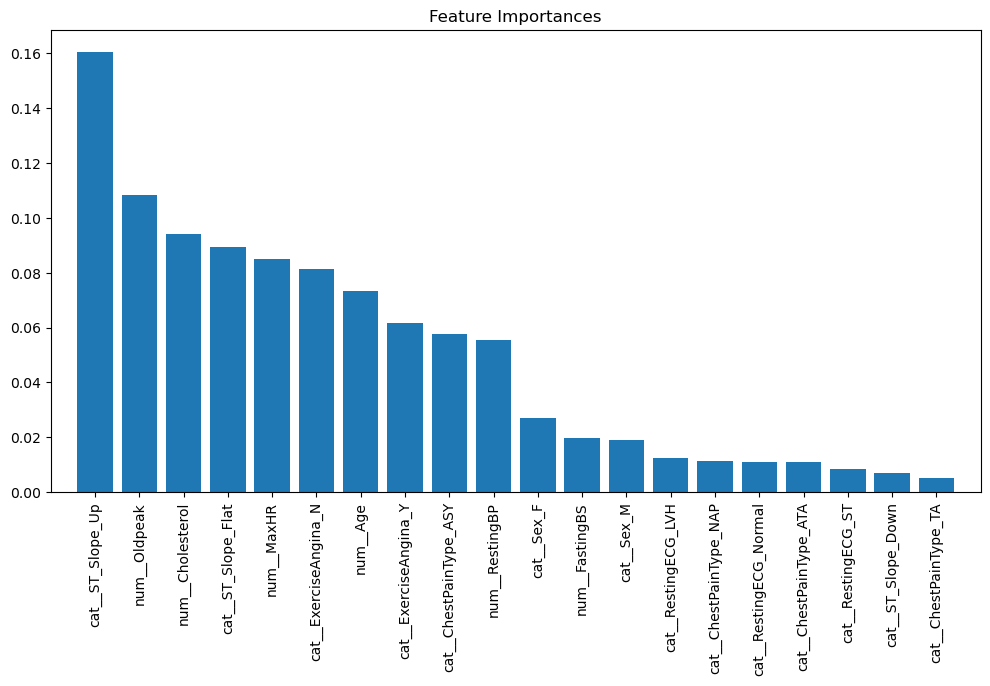

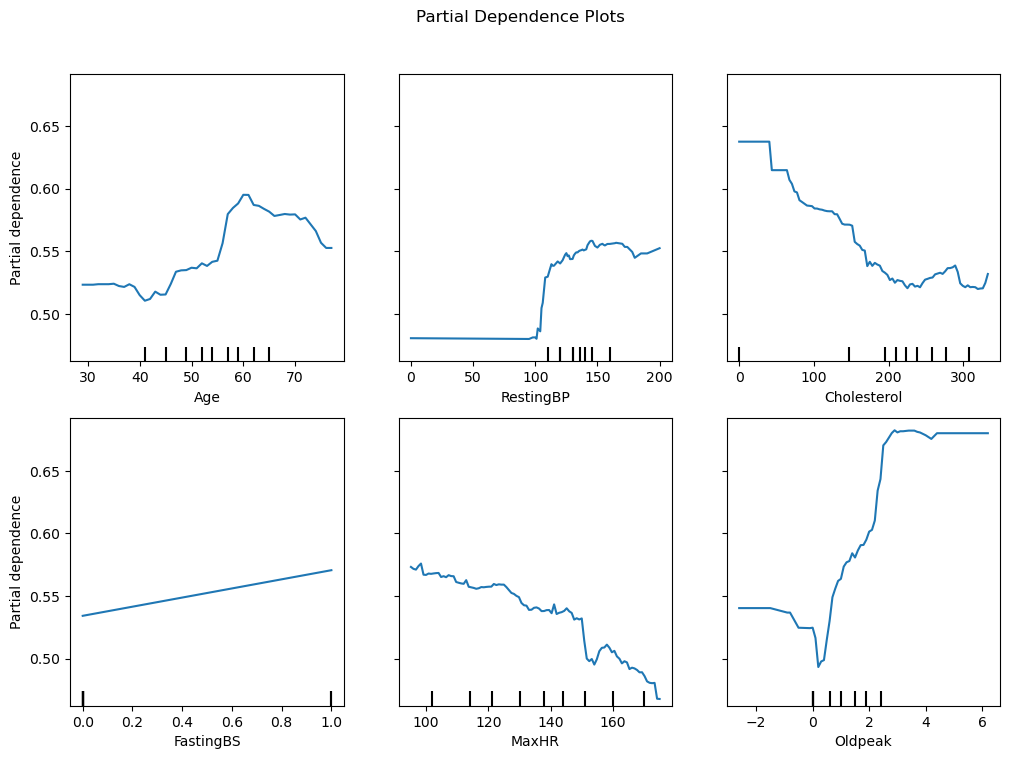

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Load the Dataset
data = pd.read_csv('heart.csv')

# Inspect the data to understand its structure
print(data.head())
print(data.info())
print(data.describe())

# Separate features and target
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

# Identify categorical and numerical columns
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_columns = [col for col in X.columns if col not in categorical_columns]

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create a pipeline that combines preprocessing and model training
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Model Evaluation
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Print classification report and accuracy
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# SHAP Values for Feature Importance
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)

# Summarize SHAP Values
shap.summary_plot(shap_values, X_test_transformed, feature_names=best_model.named_steps['preprocessor'].get_feature_names_out())

# Feature Importance from RandomForest
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X_test_transformed.shape[1]), importances[indices], align='center')
plt.xticks(range(X_test_transformed.shape[1]), best_model.named_steps['preprocessor'].get_feature_names_out()[indices], rotation=90)
plt.xlim([-1, X_test_transformed.shape[1]])
plt.show()

# Partial Dependence Plots
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,
    features=numerical_columns,
    ax=ax
)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)
plt.show()